In [10]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

asinToIndex = {}
index = 0
scoreMatrix = []
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=100000, 
    typ="frame", orient="records", dtype={"asin": str, "overall": int}
)

for chunk in chunks:
    for _, row in chunk.iterrows():
        asin = row["asin"]
        rate = row["overall"]

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    break # comment to load everything

scoreMatrix = np.array(scoreMatrix)
print(scoreMatrix)

[[  6   4   8  15 173]
 [  0   4   2  10   2]
 [  1   0   0   2  13]
 ...
 [  2   2   5  12  17]
 [  1   3   9  30  23]
 [  0   0   3  15  11]]


In [35]:
nbRating = np.sum(scoreMatrix, axis=1)
print(f"Nb Rating = {nbRating}")
avgRatings = (np.average(scoreMatrix, axis=1, weights=[1,2,3,4,5]) * 15) / nbRating
print(f"Average rating = {avgRatings}")
maxRating = np.max(scoreMatrix, axis=0)
minRating = np.min(scoreMatrix, axis=0)
print(f"Max Rating = {maxRating}, Min Rating = {minRating}")

Nb Rating = [206  18  16 ...  38  66  29]
Average rating = [4.67475728 3.55555556 4.625      ... 4.05263158 4.07575758 4.27586207]
Max Rating = [ 593  450  644  846 2605], Min Rating = [0 0 0 0 0]


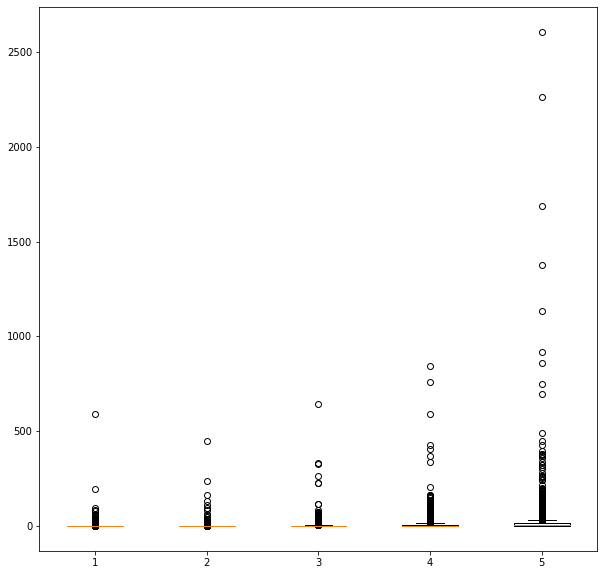

In [29]:
fig = plt.figure(figsize =(10, 10))
plt.boxplot(scoreMatrix)
plt.show()